# MIS 583 Assignment 2: Logistic Regression

Before we start, please put your name and ID in following format  
: LASTNAME Firstname, ?000000000   //   e.g.) 陳耀融, M094020099

**Your Answer:**   
Hi I'm XXX, XXXXXXXXXX

## Logistic Regression

Logistic Regression is a member of the linear model family. But not like Linear Regression that outputs a real value, Logistic Regression is used for binary classification.

In this tutorial, we will cover:
* PyTorch: Tensor operations
* Machine Learning: Logistic Regression, gradient descent, preprocessing of data

This assignment will walk you through implementing a logistic regression that classifies whether a person is rich or poor using the UCI adult income dataset in PyTorch.

The assignment is divied into two parts. 
* In part 1, you will **implement a logistic regression from scratch using PyTorch tensors and tensor operations**. This will help you gain a better understanding of the theoretical concepts discussed in class.
* In part 2, you will **use PyTorch nn.Module to build a logsitic regression** so that you will get familiar with PyTroch APIs.

In this assigment, **You CANNOT remove any assertions.**

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.9.5`, `torch==1.8.2` and `torchvision==0.9.2`

In [1]:
!python --version
import torch
import torchvision
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

Python 3.9.5
torch 1.8.2
torchvision 0.9.2


## Prepare Data

### Load Data

We use [adult income](https://www.kaggle.com/wenruliu/adult-income-dataset) dataset from UCI machine learning repository.  

**Abstrct**  

Given an individual’s education level, age, gender, occupation, and etc, we can predict one's income levels.   

**Metadata**  
Number of attributes: 14  
- income: >50K, <=50K
- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [2]:
# Download it from cu and upload to colab

# or from my Dropbox
!wget -q -N https://www.dropbox.com/s/1jqeipgof7tukln/data.zip
!unzip -n data.zip

Archive:  data.zip


It contain 4 csv files: X_train, X_test, Y_train and Y_test, which represent training data, training labels, test data and test labels, respectively.

Each row in X has 106 fields  
Each row Y represents the true label of 0 (poor) and 1 (rich).  

Or you can load train.csv raw data and do your pre-processing.

In [3]:
import numpy as np
import pandas as pd

# Pre-Processed Version
X_train_raw = pd.read_csv('data/X_train.csv')
Y_train_raw = pd.read_csv('data/Y_train.csv')
X_test_raw = pd.read_csv('data/X_test.csv')
Y_test_raw = pd.read_csv('data/Y_test.csv')

X_train_raw.head()

# Or you can do preprocess by yourself
# df = pd.read_csv('data/train.csv')
# ...some preprocessing
# ...remember split into 4 variables with same name by yourself

,age,fnlwgt,sex,capital_gain,capital_loss,hours_per_week,Federal-gov,Local-gov,Never-worked,Private,...,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,?_native_country
0,39,77516,1,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,1,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,1,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,1,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,0,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


You already notice that there are two datasets.   One is called "training set", and another is called "testing set".  
Training set is like **homework of model**. Model will do it serval times and get correct answer to improve itself.  
Testing set is like **quiz of model**. Testing set only provide x and evaluate how good your model is.  
Train-Test-Split could prevent our model from overfitting by check performence between two datasets.



### Pre-Processing Data (10 points)

In a data science process, data cleansing usually cost the most of time.  
Dirty data will cause overfitting or make us ignore those important features. Even if you don't have correct cleansing and format, your model can't run anymore.

In [4]:
import torch
################################################################################
# TODO: Implement Standard Deviation Normalization mentioned in class.         #
# train_data has shape(n_train, feature_dim)                                   #
# test_data has shape(n_test, feature_dim)                                     #
# hint: You should count mean and std in training, and apply it to test.       #
################################################################################
def compute_mu_std(data):
    '''
    Arguments:
    data -- torch.Tesor, contain data with shape(n, feature_dim)

    Return:
    mu - torch.Tensor, mean value of columns of data with shape(feature_dim)
    sigma - torch.Tensor, std value of columns of data with shape(feature_dim)
    '''
    mu = data.mean(dim=0)
    sigma = data.std(dim=0)
    return mu, sigma

def standard_normalize(data, mu, std):
    '''
    Arguments:
    data -- torch.Tesor, contain data with shape(n, feature_dim)
    mu - torch.Tensor, mean value of columns of data with shape(feature_dim)
    sigma - torch.Tensor, std value of columns of data with shape(feature_dim)

    Return:
    data -- torch.Tensor, normalized data with given mu and sigma
    '''
    data = (data - mu) / std
    return data

X_train = torch.tensor(X_train_raw.values, dtype=torch.float)
X_test = torch.tensor(X_test_raw.values, dtype=torch.float)

mu, sigma = compute_mu_std(X_train)

# output the first 5 values of mu and sigma
print('the first 5 means are:', mu[:5])
print('the first 5 sigma are:', sigma[:5])

f_dim = X_train.shape[1]
assert mu.shape == torch.Size([f_dim]), 'Shape of mu is incorrect.'
assert sigma.shape == torch.Size([f_dim]), 'Shape of sigma is incorrect.'

X_train = standard_normalize(X_train, mu, sigma)
X_test = standard_normalize(X_test, mu, sigma)
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################
# make shape(n, 1) > shape(n), like [[1, 2, 3]] > [1, 2, 3]
Y_train = torch.tensor(Y_train_raw.values).squeeze()
Y_test = torch.tensor(Y_test_raw.values).squeeze()

print('Shape of X_train:', X_train.shape) 
print('Shape of X_test:', X_test.shape)  
print('Shape of y_train:', Y_train.shape)
print('Shape of y_test:', Y_test.shape)


assert X_train.dim() == 2
assert Y_train.dim() == 1
# You can ONLY change assertion are there.
# IF you are writting YOUR pre-processing, cuz you will have different shape.
assert X_train.shape == (32561, 106)
assert X_test.shape == (16281, 106)

the first 5 means are: tensor([3.8582e+01, 1.8978e+05, 6.6921e-01, 1.0776e+03, 8.7304e+01])
the first 5 sigma are: tensor([1.3640e+01, 1.0555e+05, 4.7051e-01, 7.3853e+03, 4.0296e+02])
Shape of X_train: torch.Size([32561, 106])
Shape of X_test: torch.Size([16281, 106])
Shape of y_train: torch.Size([32561])
Shape of y_test: torch.Size([16281])


Beacause the size of dataset used in Deep Learning and Computer Vision field usually be ginormous.  You can not load you model and whole dataset into memory(GPU or RAM) in the same time.  
Mini-Batch SGD method mentioned in class come in handy. We will split dataset into batches.

In [5]:
def make_batch(data, batch_size=128, drop_last=True):
    '''
    Split dataset into batches.

    Arguments:
    data -- torch.Tensor, data with shape(n, ...)
    batch_size -- int, how many data in your batch
    drop_last -- boolean, drop last datas if your remaining data is < batch_size

    Return:
    out -- torch.Tensor(dtype=torch.float) with shape(n_batch, batch_size, ...)
    '''
    if drop_last:
        n = data.shape[0] // batch_size
    else:
        n = ((data.shape[0] - 1) // batch_size) + 1
    out = np.empty(torch.Size((n, batch_size)) + data.shape[1:], dtype=np.float32)
    print(out.shape)
    for b in range(len(out)):
        out[b] = data[b * batch_size:(b + 1) * batch_size]
    return torch.tensor(out)

X_train_batch = make_batch(X_train)
Y_train_batch = make_batch(Y_train)
X_test_batch = make_batch(X_test)
Y_test_batch = make_batch(Y_test)

(254, 128, 106)
(254, 128)
(127, 128, 106)
(127, 128)


Finally! We have made all data prepared.  
Let's go develop our model.

# Part 1: Implement Logistic Regression from Scratch

## Utility function

### Activation Function (5 points)

The biggest difference between Logistic Regression and Linear Regression is activation function.  
Logistic Regression use logistic function(or called sigmoid function)  
It takes any real input t and outputs a value between zero and one.  

**Slide: ch02 p66**

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/640px-Logistic-curve.svg.png)

*Source: wikipedia*

In [6]:
def sigmoid(z): 
    '''
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or torch.Tensor of any size.

    Return:
    s -- torch.Tensor, sigmoid(z)
    '''
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z, dtype=torch.float)
    ############################################################################
    # TODO: Implement sigmoid(or called logistic) function                     #
    # Slide: ch02 p66                                                          #
    ############################################################################
    out = 1 / (1 + torch.exp(-z))
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    # prevent out is Inf or -Inf
    out = torch.clamp(out, 1e-6, 1-1e-6)
    return out

s_t1 = sigmoid(0)
s_t2 = sigmoid(2)
s_t3 = sigmoid(-1)
print('sigmoid(0)  =', s_t1)
print('sigmoid(2)  =', s_t2)
print('sigmoid(-1) =', s_t3)
msg = 'Your sigmoid: {} isn\'t correct'
assert (s_t1 - 0.5) < 0.001, msg.format(sigmoid(0))
assert (s_t2 - 0.8808) < 0.001, msg.format(sigmoid(2))
assert (s_t3 - 0.2689) < 0.001, msg.format(sigmoid(-1))

sigmoid(0)  = tensor(0.5000)
sigmoid(2)  = tensor(0.8808)
sigmoid(-1) = tensor(0.2689)


### Loss Function (10 points)

Cross Entropy is very important in information theory.  
It calculate the difference between two probability distributions.  
**Slide: ch03 p85**

In [7]:
def binary_cross_entropy(y_true, y_pred):
    '''
    Compute the binary cross entropy of inputs.

    Arguments:
    y_true -- torch.Tensor, True data with shape(n_size).
    y_pred -- torch.Tensor, Predicted data with shape(n_size)

    Return:
    s -- torch.Tensor, binary_cross_entropy(z)
    '''
    ############################################################################
    # TODO: Implement binary cross entropy                                     #
    # Slide: ch02 p85                                                          #
    ############################################################################
    loss = y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)
    loss = -torch.mean(loss)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    return loss

b_t1 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.5]))
b_t2 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.8]))
b_t3 = binary_cross_entropy(torch.tensor([1]), torch.tensor([0.9]))
print('bce(1, 0.5)', b_t1)
print('bce(1, 0.8)', b_t2)
print('bce(1, 0.9)', b_t3)
msg = 'Your bce: {} isn\'t correct'
assert (b_t1 - 0.6931) < 0.001, msg.format(b_t1)
assert (b_t2 - 0.2231) < 0.001, msg.format(b_t1)
assert (b_t3 - 0.1054) < 0.001, msg.format(b_t1)

bce(1, 0.5) tensor(0.6931)
bce(1, 0.8) tensor(0.2231)
bce(1, 0.9) tensor(0.1054)


## Logistic Regression Model (50 points)

We are almost there!  
Next step(the last step), we will combine all of them together.  
Get our model work, count the loss, get the gradinet and using gradient-descent method to update our model.  
**Slide: ch02 p99 Training algorithm with mini-batch SGD**
 
Good luck!
```python
num_epochs = ... # specify the number of epochs to train initialize parameters w, b
for epoch in range(num_epochs):
    shuffle training data
    for each batch:
        forward propagation to get the predictions/outputs 
        compute loss
        backward propagation to get the gradients
        update parameters using their gradients
```

You should fill out each methods(init, forward, backward, optimizer...)  
Inputs, outputs, format and description is written in docstring `'''doc string there'''`  
**You CANNOT remove any assertion.**

In [ ]:
############################################################################
# Implement Logistic Regression module                                     #
############################################################################
class LogisticRegression:
    def __init__(self, lr, feature_dim):
        '''
        Initiate learn_rate
        Initiate weights and bias to zeros with correct shape.
        w and b should be torch.tensor(...)
        The shape of w should be (feature_dim)
        The shape of b should be (1)

        Arguments:
        lr -- float, learn_rate to update weight (0 < lr <= 1).
        feature_dim -- int, How many features your data have.
        '''
        self.w = torch.zeros(feature_dim)
        self.b = torch.tensor(0, dtype=torch.float)
        self.lr = lr
        assert self.w.shape == torch.Size([feature_dim]), 'shape of w is incorrect'
        assert self.b.dtype == torch.float, 'dtype of b should be float'

        # initialize dw, db to zeros
        self.grads = {'dw': torch.zeros(feature_dim, dtype=torch.float), 
                      'db': torch.tensor(0, dtype=torch.float)}

    def forward(self, x):
        '''
        Compute Logistic Regression using our w and b for input x.
        Store it in self.out, backward need it.

        Arguments:
        x -- torch.Tensor, input data with shape(n, feature_dim).

        Return:
        out -- sigmoid(x * w + b)
        '''
        out = torch.matmul(x, self.w) + self.b
        out = sigmoid(out)
        self.out = out
        assert (out > 0).all() and (out < 1).all(), 'Output should > 0 and < 1'
        assert out.shape == torch.Size([x.shape[0]]), 'Shape of output is incorrect.'
        return self.out
    
    def backward(self, x, y_true):
        '''
        After forward, calculate gradient of w and b(dw and db).
        Store dw and db in self.grads.

        Arguments:
        x -- torch.Tensor, input data with shape(n,).
        y_true -- torch.Tensor, true data with shape(n,).
        '''
        y_pred = self.out
        
        ########################################################################
        #                           Your code there                            #
        # Slide: ch02 p95 Gradient descent implementation                      #
        ########################################################################
        error = y_pred - y_true
        dw = torch.matmul(x.T, error) / x.shape[0]
        db = error.mean()
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        assert dw.shape == self.w.shape, 'Shape of dw is incorrect.'
        assert db.shape == self.b.shape, 'Shape of db is incorrect.'

        self.grads = {'dw': dw, 'db': db}

    def optimize(self):
        '''
        Implement SGD algorithm.
        Use gradient and lr update weight and bias.
        Remember store back into class.
        '''
        ########################################################################
        #                           Your code there                            #
        # Slide: ch02 p95 Gradient descent implementation                      #
        ########################################################################
        dw, db = self.grads['dw'], self.grads['db']
        self.w -= self.lr * dw
        self.b -= self.lr * db
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def predict(self, x):
        '''
        Compute output of our model like forward method.
        But append a threshold x > 0.5 to output label.
        hint: you should re-use forward method

        Arguments:
        x -- torch.Tensor, input data with shape(n, feature_dim).

        Return:
        out -- sigmoid(x * w + b) > 0.5 with shape(n,)
        '''
        out = self.forward(x)
        out = out > 0.5 # turn into 0 or 1 label
        assert out.shape == torch.Size([x.shape[0]]), 'Shape of output is incorrect'
        return out
################################################################################
#                             END OF YOUR CODE                                 #
################################################################################

In [ ]:
################################################################################
#                             Hyper Parameters                                 #
# You can modify these parameter to achieve higher accuracy                    #
################################################################################
lr = 3e-2
max_epochs = 50
log_interval = 5

model = LogisticRegression(lr=lr, feature_dim=X_train.shape[1])

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

### Put everything together (5 points)

In [ ]:
from sklearn.metrics import accuracy_score

for epoch in range(1, max_epochs + 1):
    idxs = torch.randperm(X_train_batch.shape[0]) # make rand idx
    data_loader = ((X_train_batch[i], Y_train_batch[i]) for i in idxs)

    loss_list = [] # save train_loss
    for i, (x, y) in enumerate(data_loader):
        ########################################################################
        # TODO: Combine all the functions together                             #
        ########################################################################
        # hints:
        # 1. get output from forward method, call forward()
        # 2. calculate loss using binary_cross_entropy()
        # 3. using backward method to calculate dw, db, call backward()
        # 4. apply SGD optimize to update model's weights, call optimize()
        out = model.forward(x)
        loss = binary_cross_entropy(y, out)
        model.backward(x, y)
        model.optimize()
        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        loss_list.append(loss)

    train_loss_list.append(sum(loss_list) / len(loss_list))
    train_acc_list.append(accuracy_score(Y_train, model.predict(X_train.float())))
    test_loss_list.append(binary_cross_entropy(Y_test, model.forward(X_test.float())))
    test_acc_list.append(accuracy_score(Y_test, model.predict(X_test.float())))
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train loss:', train_loss_list[-1], 'acc:', train_acc_list[-1])
        print('Test loss: ', test_loss_list[-1], 'acc:', test_acc_list[-1])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

# Part 2: Implement Logsitic Regression Using PyTorch nn.Module APIs

Congratulation! It is all the details of Logistic Regression.  
Now, I will show you how to implement it by PyTorch in few lines.    
You would be amazed by this powerful and beautiful tool, maybe.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

Let's start with PyTorch Dataset.  
You can notice there are dataset and data_loader two classes.
Dataset handle the whole dataset.
Dataloader provide batch, shuffle and many more utility functions about Dataset.  
We will dicuss more later.

Use `TensorDataset` and `DataLoader` from `torch.utils.data`.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, Y_train.unsqueeze(dim=1).float())
test_dataset = TensorDataset(X_test, Y_test.unsqueeze(dim=1).float())
train_data = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=128, shuffle=False)

PyTorch provide very convienece way to construct your model.  
There are the instructions for you to follow.  
1. Create your class inherit `nn.Module`.  
2. In `__init__` method, call `super().__init__()` and define your model layers.  
3. In `forward()` method, connect all your layers to do computation.

PyTorch will using [autograd mechanic](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) to generate `backward()` and get gradient **automatically**.  
We get the same model with less effort.

### Define a logistic regression using nn.Module (10 points)

In [14]:
class TorchLogisticRegression(nn.Module):
    def __init__(self, feature_dim):
        '''
        Initiate weights and bias of our model.

        Arguments:
        feature_dim -- int, How many features your data have.
        '''
        super().__init__()
        # init the weight AND bias by nn.Linear
        ########################################################################
        # TODO: use nn.xxx method to generate a linear model part              #
        #   you can define one layer with wieght and bias                      #
        ########################################################################
        self.linear = nn.Linear(feature_dim, 1, bias=True)
        # YR: bias is default=True, just for hightlight
        ########################################################################
        #                           End of your code                           #
        ########################################################################
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        ########################################################################
        # TODO: forward your model and get output                              #
        #   Don't forget activation function. But, you can't use previous      #
        #   defined sigmoid, try to search in PyTorch docs                     #
        ########################################################################
        out = self.linear(x)
        out = torch.sigmoid(out)
        assert out.shape == torch.Size([x.shape[0], 1]), 'Shape of output is incorrect'
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer (5 points)

In [15]:
# 106 features in our income dataset
torch_model = TorchLogisticRegression(X_train.shape[1])
 
########################################################################
# TODO: Define loss and optmizer functions                             #
#   please use Binary Cross Entropy and SGD optimizer                  #
# hint: torch.nn and torch.optim                                       #
########################################################################
criterion = nn.BCELoss(reduction='mean') # YR: same, just for hightlight
params = torch_model.parameters()
optimizer = torch.optim.SGD(params, lr=3e-2)
########################################################################
#                           End of your code                           #
########################################################################

### Train the model (5 points)

Let's define train function.  
It will iterate inputed data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

In [16]:
def train(data, model, criterion, optimizer):
    '''
    Argement:
    data -- iterable data, type torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optimizer function, method for weight updating
    '''
    model.train()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    for x, y in data:
        optimizer.zero_grad()

        ########################################################################
        # Training part with data, model, criterion and optimizer              #
        ########################################################################
        # Like training part we implement above, but PyTorch version
        # 1. get output from model, use model()
        # 2. calculate loss using criterion(y_pred, y_true)
        # 3. backward method of loss to calculate gradient
        # 4. call optimizer to update model's weights
        out = model(x) # model out
        loss = criterion(out, y) # get loss
        loss.backward() # get gradients
        optimizer.step() # gradient-descent
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        total_count += out.shape[0]
        acc_count += ((out > 0.5) == y).sum().item()
        loss_list.append(loss.item())
    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

Next part is test function.  
It works as training function without optmizer and weigght-updating part.

In [17]:
def test(data, model, criterion):
    model.eval()
    
    loss_list = []
    total_count = 0
    acc_count = 0
    with torch.no_grad():
        for x, y in data:
            ####################################################################
            # Testing part with data, model and criterion                      #
            ####################################################################
            # Like training part without weight updating
            # 1. get output from model, use model()
            # 2. calculate loss using criterion(y_pred, y_true)
            out = model(x)
            loss = criterion(out, y)
            ####################################################################
            #                           End of your code                       #
            ####################################################################

            total_count += out.shape[0]
            acc_count += ((out > 0.5) == y).sum().item()
            loss_list.append(loss.item())

    acc = acc_count / total_count
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

There is truly final step!  
Call train and test function in a loop.  
Take a break and wait.

In [18]:
# Hyper Parameters
max_epochs = 50
log_interval = 5

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_data, torch_model, criterion, optimizer)
    test_acc, test_loss = test(test_data, torch_model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(test_acc, test_loss))

==================== Epoch 5 ====================
Train Acc: 0.847855 Train Loss: 0.328671
Test Acc: 0.848412 Test Loss: 0.326332
==================== Epoch 10 ====================
Train Acc: 0.851786 Train Loss: 0.321705
Test Acc: 0.850193 Test Loss: 0.321191
==================== Epoch 15 ====================
Train Acc: 0.851847 Train Loss: 0.319420
Test Acc: 0.851422 Test Loss: 0.319690
==================== Epoch 20 ====================
Train Acc: 0.852523 Train Loss: 0.318515
Test Acc: 0.852405 Test Loss: 0.318867
==================== Epoch 25 ====================
Train Acc: 0.852646 Train Loss: 0.317914
Test Acc: 0.852159 Test Loss: 0.318530
==================== Epoch 30 ====================
Train Acc: 0.852984 Train Loss: 0.317680
Test Acc: 0.852589 Test Loss: 0.318436
==================== Epoch 35 ====================
Train Acc: 0.853475 Train Loss: 0.317331
Test Acc: 0.852343 Test Loss: 0.318553
==================== Epoch 40 ====================
Train Acc: 0.853168 Train Loss: 0

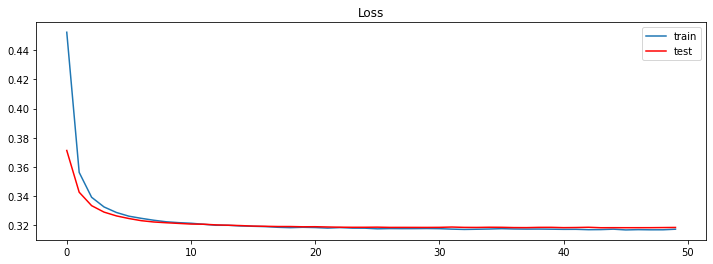

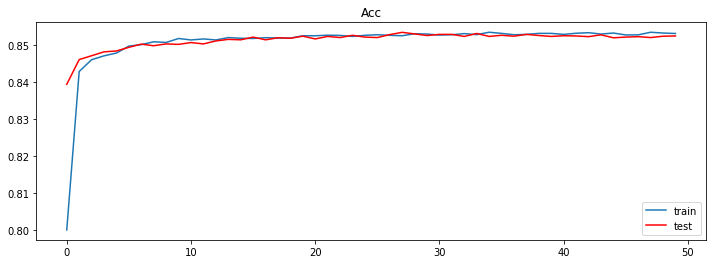

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()

In [20]:
# Comparison of our model and torch's model
print('-' * 20, 'weight' , '-' * 20)
print('Ours', model.w[:20])
print('PyTorch', torch_model.linear.weight[0][:20])
print('-' * 20, 'bias' , '-' * 20)
print('Ours', model.b)
print('PyTorch', torch_model.linear.bias)

-------------------- weight --------------------
Ours tensor([ 0.3439,  0.0754,  0.3989,  2.1787,  0.2595,  0.3706,  0.1052, -0.0104,
        -0.0378,  0.0597,  0.0499, -0.0991, -0.0325, -0.0896, -0.0712, -0.1893,
        -0.1945, -0.0713, -0.1192, -0.1384])
PyTorch tensor([ 3.4526e-01,  7.4578e-02,  3.9665e-01,  2.1785e+00,  2.6148e-01,
         3.6745e-01,  1.0473e-01,  1.7587e-03, -5.1543e-02,  8.0185e-02,
         5.9694e-02, -8.8349e-02, -2.8569e-02, -8.8690e-02, -2.3557e-02,
        -1.9478e-01, -1.9828e-01, -7.4193e-02, -1.2027e-01, -1.3886e-01],
       grad_fn=<SliceBackward>)
-------------------- bias --------------------
Ours tensor(-2.0751)
PyTorch Parameter containing:
tensor([-2.0783], requires_grad=True)


Their weights and bias almost be the same.  
We got similar results, but with less effort!  
Let's meet PyTorch and be its friend in the next few weeks!  

# Part 3: Build MLP(Multiple Layer Perceptron) using PyTorch

It's a small section about replacing Logistic Regression with MLP.  
Increasing the numbers of layer will bring the greater capacity.  

Some of the above instructions has been done. We can reuse them.  
So, we just need to do the rest instructions.  

1. (reuse) Prepare the dataset
2. Build the model
3. Define Optimizer and Loss
4. (reuse) Define Train and Test Function
5. Run Training Loop

In [21]:
# Step 2: re-define a model
class TorchMLP(nn.Module):
    def __init__(self, feature_dim):
        '''
        Initiate weights and bias of our model.

        Arguments:
        feature_dim -- int, How many features your data have.
        '''
        super().__init__()
        # init the weight AND bias by nn.Linear
        ########################################################################
        # TODO: use nn.xxx method to MLP layer                                 #
        #   output of previous layer should fit input of the next layer        #
        ########################################################################
        self.linear1 = nn.Linear(feature_dim, 30)
        self.linear2 = nn.Linear(30, 10)
        self.linear3 = nn.Linear(10, 1)
        self.act = nn.Sigmoid()
        self.drop = nn.Dropout(0.2)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
    
    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        ########################################################################
        # TODO: forward your model and get output                              #
        #   Don't forget activation function. But, you can't use previous      #
        #   defined sigmoid, try to search in PyTorch docs                     #
        ########################################################################
        out = self.act(self.linear1(x))
        out = self.drop(out)
        out = self.act(self.linear2(out))
        out = self.drop(out)
        out = self.linear3(out)
        out = torch.sigmoid(out)
        assert out.shape == torch.Size([x.shape[0], 1]), 'Shape of output is incorrect'
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

This part is the same.  
You should try modifying settings to achieve the better result.  
You can try:
- Different activation
- Deeper layers
- Add some Normalization or Tricks(dropout, BatchNorm)

**But, deeper MLP is hardly performing good as Logistic Regression.**  
**Your goal is get a result "test acc >= 75%"**

In [22]:
# Step 3: Define Optimizer and Loss
mlp_model = TorchMLP(X_train.shape[1])
 
########################################################################
# TODO: Define loss and optmizer functions                             #
#   please use Binary Cross Entropy and SGD optimizer                  #
#   You should could try different settings of anything                #
########################################################################
criterion = nn.BCELoss(reduction='mean')
params = torch_model.parameters()
optimizer = torch.optim.SGD(params, lr=3e-2)
########################################################################
#                           End of your code                           #
########################################################################

<!-- ## Normal Logistic
Train Acc: 0.853321 Train Loss: 0.316691
Test Acc: 0.852282 Test Loss: 0.318421
 -->

In [23]:
# Step 5: Training Loop
max_epochs = 30
log_interval = 3

train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = train(train_data, mlp_model, criterion, optimizer)
    test_acc, test_loss = test(test_data, mlp_model, criterion)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('Test Acc: {:.6f} Test Loss: {:.6f}'.format(test_acc, test_loss))

==================== Epoch 3 ====================
Train Acc: 0.719480 Train Loss: 0.649860
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 6 ====================
Train Acc: 0.720647 Train Loss: 0.649824
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 9 ====================
Train Acc: 0.720156 Train Loss: 0.649523
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 12 ====================
Train Acc: 0.718313 Train Loss: 0.649966
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 15 ====================
Train Acc: 0.715918 Train Loss: 0.649830
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 18 ====================
Train Acc: 0.719757 Train Loss: 0.649908
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 21 ====================
Train Acc: 0.719726 Train Loss: 0.649603
Test Acc: 0.763774 Test Loss: 0.646663
==================== Epoch 24 ====================
Train Acc: 0.718375 Train Loss: 0.6

### Report MLP performance(15 points)
Get a result test acc >= 75%(5 points)

Please report your setting and performance(10 points).  
You should compare at lease 5 settings try to achieve 75% test acc

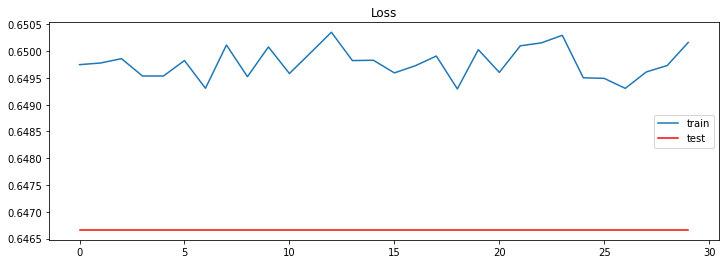

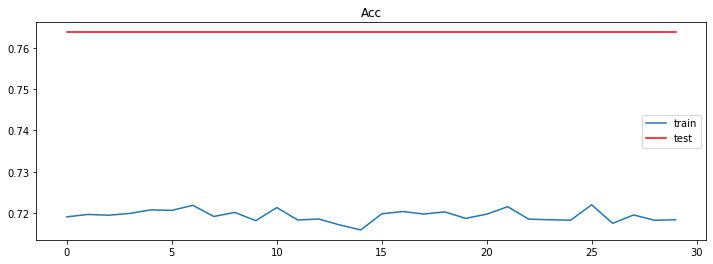

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list, c='r')
plt.legend(['train', 'test'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list, c='r')
plt.legend(['train', 'test'])
plt.title('Acc')
plt.show()